In [1]:
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from tqdm.notebook import trange

In [2]:
from src.box import GravityHoleBall
from src.utils import add_spatial_encoding, gaussian_density
from src.models import ConvAE
from src.viz import plot_tsne_and_pca, plot_tsne_and_pca_portrait
from src.ode import ODEnetSimple, train, BatchGetterMultiTrajectories
from src.anode import ANODENet

In [3]:
MARGIN_MIN = 3
MIN_INIT_VELOCITY = 200.
WIDTH, HEIGHT = 28, 28
RADIUS = 3


In [4]:
x = WIDTH/4.
y = HEIGHT/4.
vx = 0.
vy = 0.

box = GravityHoleBall(x, y, vx, vy, (WIDTH, HEIGHT),RADIUS)

# Fit an ODE on the true position + velocity using several trajectories

In [5]:
def generate_gravity_hole_ball_positions_and_velocity(box, N, N_frames, dt):
    dataset = []
    
    for _ in trange(N):
        x, y = np.random.uniform(MARGIN_MIN, WIDTH - 1 - MARGIN_MIN, 2)

        vx, vy = np.random.uniform(-MIN_INIT_VELOCITY, MIN_INIT_VELOCITY, 2)

        box.reset(x0=x, y0=y, vx0=vx, vy0=vy)
        trajectory = []

        x, y = box.position
        vx, vy = box.velocity
        modified_position = ( np.array([x, y]).copy() - np.array([WIDTH/2., HEIGHT/2.]))/np.array([WIDTH, HEIGHT])
        modified_velocity = np.array([vx, vy])/(WIDTH*HEIGHT)
        trajectory.append(np.concatenate((modified_position, modified_velocity), axis=0))

        for _ in range(N_frames - 1):
            x, y = box.move(dt)
            vx, vy = box.velocity
            modified_position = ( np.array([x, y]).copy() - np.array([WIDTH/2., HEIGHT/2.]))/np.array([WIDTH, HEIGHT])
            modified_velocity = np.array([vx, vy])/(WIDTH*HEIGHT)
            trajectory.append(np.concatenate((modified_position, modified_velocity), axis=0))

        dataset.append(trajectory)

    return np.array(dataset)

In [6]:
N = 200
N_frames = 300
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)

encoded_trajectory = generate_gravity_hole_ball_positions_and_velocity(box, N, N_frames, dt)
print(encoded_trajectory.shape)



  0%|          | 0/200 [00:00<?, ?it/s]

(200, 300, 4)


In [52]:
batch_time = 200
n_samples = 1
total_length = N_frames

getter = BatchGetterMultiTrajectories(batch_time, n_samples, total_length, dt, encoded_trajectory, frac_train=1.)

In [53]:

def display_results(i, model, getter, final_time, dt):

    print("The graphs at epoch {}".format(i))
    with torch.no_grad():
        index = np.random.randint(0, getter.N_train)

        times = torch.linspace(0., final_time*dt, final_time, dtype=torch.float64).float()

        y0, t, y = getter.get_batch()
        predicted_output = model(getter.train_positions[index, 0].unsqueeze(0), times)
        # display in orange the predicted position and in blue the true position of the training set
        
        # pca = PCA(n_components=2).fit(getter.train_positions[index].numpy())
        # pca_encoded_trajectory = pca.transform(predicted_output[:, -1].detach().numpy())
        # # print(getter.train_positions[index].shape)
        # pca_train_trajectory = pca.transform(getter.train_positions[index].numpy())

        # pca = PCA(n_components=2).fit(getter.train_positions[index].numpy())

        pca_encoded_trajectory = predicted_output[:, -1, :2].detach().numpy()
        # print(getter.train_positions[index].shape)
        pca_train_trajectory = getter.train_positions[index, :, :2]

        plt.plot(pca_encoded_trajectory[:,0], 
                pca_encoded_trajectory[:,1], 'orange', label="Predicted")

        plt.plot(pca_train_trajectory[:,0], pca_train_trajectory[:,1], 'b', label="Ground truth")

        plt.xlabel("First coord")
        plt.ylabel("Second coord")
        plt.legend()
        plt.show()

       

        # print the X axis over the time
        plt.plot(times, pca_train_trajectory[:,0], 'r', label="Ground truth Coord 1")
        plt.plot(times, pca_encoded_trajectory[:,0], 'orange', label="Predicted Coord 1")
        plt.xlabel("Time")
        plt.ylabel("First coord of PCA")
        plt.legend()
        plt.show()

        plt.plot(times, pca_train_trajectory[:,1], 'r', label="Ground truth Coord 2")
        plt.plot(times, pca_encoded_trajectory[:,1], 'orange', label="Predicted Coord 2")
        plt.xlabel("Time")
        plt.ylabel("Second coord of PCA")
        
        
        # pca_encoded_trajectory = predicted_output[:, -1].detach().numpy()
        # pca_train_trajectory = getter.train_positions[index].numpy()
        # plt.plot(times, pca_train_trajectory[:], 'r', label="Ground truth Coord 1")
        # plt.plot(times, pca_encoded_trajectory[:], 'orange', label="Predicted Coord 1")
        plt.legend()
        plt.show()



In [54]:
latent_dim = 4
device = "cpu"
data_dim = latent_dim
hidden_dim = 64
output_dim = latent_dim
augment_dim = 0
anode = ANODENet(device, data_dim, hidden_dim, output_dim, augment_dim, time_dependent=False)

The graphs at epoch 0


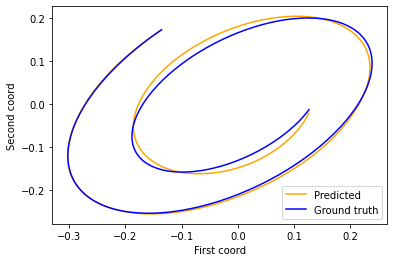

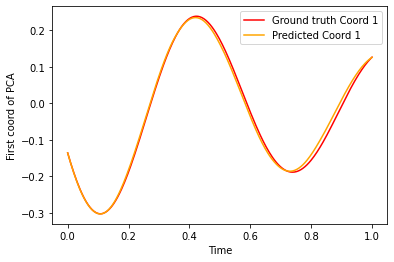

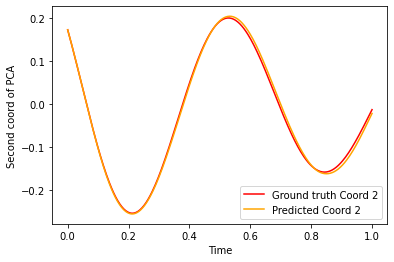

In [68]:
display_results(0, anode, getter, final_time=N_frames, dt=dt)

In [63]:
optimizer = torch.optim.Adam(anode.parameters(), lr=4e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
batch_size = 1
epochs = 100000

In [ ]:
train(anode, optimizer, scheduler, epochs, batch_size, getter, display=5000, display_results_fn=display_results)

In [70]:
# save the anode model that generalized true position
pathODE = "models/AE_ODE/anode_on_ground_truth_values_gravity_1_ball_{}_{}_{}_more_friction_and_gravity".format(latent_dim, hidden_dim, augment_dim)
torch.save(anode.state_dict(), pathODE)

# Fit an ODE on the latent position + latent approximation velocity using several trajectories

In [5]:
def generate_gravity_hole_ball_images(box, N, N_frames, dt):
    dataset = []
    INDICES_MATRIX = np.array([[i,j] for i in range(WIDTH) for j in range(HEIGHT)])

    for _ in trange(N):
        x, y = np.random.uniform(MARGIN_MIN, WIDTH - 1 - MARGIN_MIN, 2)

        vx, vy = np.random.uniform(-MIN_INIT_VELOCITY, MIN_INIT_VELOCITY, 2)

        box.reset(x0=x, y0=y, vx0=vx, vy0=vy)
        
        trajectory = []

        x, y = box.move(0.)
        ball_img = gaussian_density(INDICES_MATRIX, np.array([x, y]), RADIUS).reshape(WIDTH, HEIGHT).numpy()
        ball_img = (ball_img - ball_img.min())/(ball_img.max() - ball_img.min())
        trajectory.append(ball_img)
        for _ in range(N_frames - 1):
            x, y = box.move(dt)
            ball_img = gaussian_density(INDICES_MATRIX, np.array([x, y]), RADIUS).reshape(WIDTH, HEIGHT).numpy()
            # normalize it
            ball_img = (ball_img - ball_img.min())/(ball_img.max() - ball_img.min())
            trajectory.append(ball_img.copy())

        dataset.append(trajectory)

    return np.array(dataset)

In [6]:
N = 50
N_frames = 301
dt = 1./N_frames

times = np.arange(0, N_frames*dt, dt)

# encoded_trajectory = generate_gravity_hole_ball_positions(box, N=N, N_frames=N_frames, dt=dt)[:,:,:]
# print(encoded_trajectory.shape)

dataset = generate_gravity_hole_ball_images(box, N=N, N_frames=N_frames, dt=dt).reshape(-1, 1, HEIGHT, WIDTH)
print(dataset.shape)
dataset = [(image, 0) for image in dataset]
dataset = add_spatial_encoding(dataset)
print(len(dataset), len(dataset[0]))

  0%|          | 0/50 [00:00<?, ?it/s]

(15050, 1, 28, 28)
15050 2


In [7]:
latent_dim = 3
# path = "models/AE/ae_1_Ball_with_sp_latent_{}.pth".format(latent_dim)
path = "models/AE/ae_1_Ball_with_sp_latent_{}_no_relu.pth".format(latent_dim)
ae = ConvAE(height=HEIGHT, width=WIDTH, in_channels=3, latent_dim=latent_dim, relu=False)
print(ae.load_state_dict(torch.load(path)))

images = torch.tensor([image for image, _ in dataset]).float()
print(images.shape)
encoded_trajectory = ae.encode(images).reshape(N, N_frames, latent_dim).detach()
print(encoded_trajectory.shape)

# prepare data to contains positions and velocity
encoded_velocity = (encoded_trajectory[:, 1:] - encoded_trajectory[:, :-1])/dt
print(encoded_velocity.shape)
encoded_trajectory = torch.cat((encoded_trajectory[:, :-1], encoded_velocity), axis=-1)
print(encoded_trajectory.shape)

Number of parameters in the model: 225318
<All keys matched successfully>
torch.Size([15050, 3, 28, 28])
torch.Size([50, 301, 3])
torch.Size([50, 300, 3])
torch.Size([50, 300, 6])


In [8]:
batch_time = 200
n_samples = 1
total_length = N_frames - 1

getter = BatchGetterMultiTrajectories(batch_time, n_samples, total_length, dt, encoded_trajectory, frac_train=1.)

/Users/maximebonnin/Documents/X/3A/Stage/IntNeuralODE/src/ode.py:197: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.true_positions = torch.tensor(positions, dtype=torch.float64).float()


In [9]:

def display_results(i, model, getter, final_time, dt):

    print("The graphs at epoch {}".format(i))
    with torch.no_grad():
        index = np.random.randint(0, getter.N_train)

        times = torch.linspace(0., final_time*dt, final_time, dtype=torch.float64).float()

        y0, t, y = getter.get_batch()
        predicted_output = model(getter.train_positions[index, 0].unsqueeze(0), times)
        # display in orange the predicted position and in blue the true position of the training set
        
        pca = PCA(n_components=2).fit(getter.train_positions[index, :, :3].numpy())
        pca_encoded_trajectory = pca.transform(predicted_output[:, -1, :3].detach().numpy())
        # print(getter.train_positions[index].shape)
        pca_train_trajectory = pca.transform(getter.train_positions[index, :, :3].numpy())

        plt.plot(pca_encoded_trajectory[:,0], 
                pca_encoded_trajectory[:,1], 'orange', label="Predicted")

        plt.plot(pca_train_trajectory[:,0], pca_train_trajectory[:,1], 'b', label="Ground truth")

        plt.xlabel("First coord")
        plt.ylabel("Second coord")
        plt.legend()
        plt.show()

       

        # print the X axis over the time
        plt.plot(times, pca_train_trajectory[:,0], 'r', label="Ground truth Coord 1")
        plt.plot(times, pca_encoded_trajectory[:,0], 'orange', label="Predicted Coord 1")
        plt.xlabel("Time")
        plt.ylabel("First coord of PCA")
        plt.legend()
        plt.show()

        plt.plot(times, pca_train_trajectory[:,1], 'r', label="Ground truth Coord 2")
        plt.plot(times, pca_encoded_trajectory[:,1], 'orange', label="Predicted Coord 2")
        plt.xlabel("Time")
        plt.ylabel("Second coord of PCA")
        
        
        # pca_encoded_trajectory = predicted_output[:, -1].detach().numpy()
        # pca_train_trajectory = getter.train_positions[index].numpy()
        # plt.plot(times, pca_train_trajectory[:], 'r', label="Ground truth Coord 1")
        # plt.plot(times, pca_encoded_trajectory[:], 'orange', label="Predicted Coord 1")
        plt.legend()
        plt.show()

In [10]:
latent_dim = 6
device = "cpu"
data_dim = latent_dim
hidden_dim = 64
output_dim = latent_dim
augment_dim = 0
anode = ANODENet(device, data_dim, hidden_dim, output_dim, augment_dim, time_dependent=True)

The graphs at epoch 0


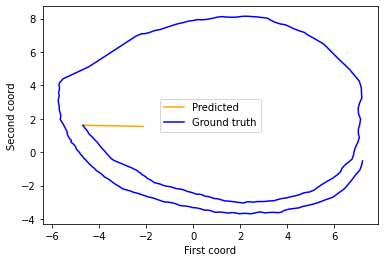

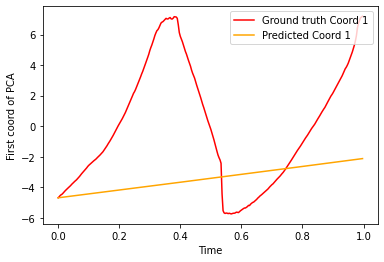

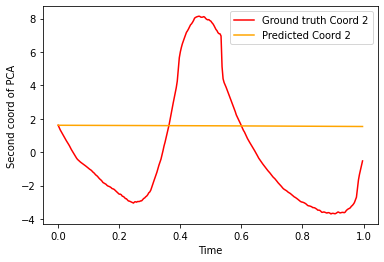

In [11]:
display_results(0, anode, getter, final_time=total_length, dt=dt)

In [12]:
optimizer = torch.optim.Adam(anode.parameters(), lr=4e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10000, gamma=0.9)
batch_size = 1
epochs = 100000

  0%|          | 0/100000 [00:00<?, ?it/s]

The graphs at epoch 500


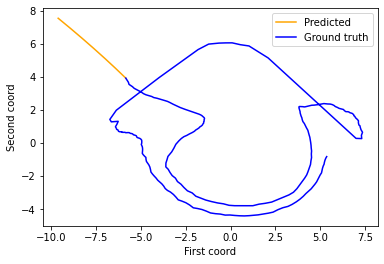

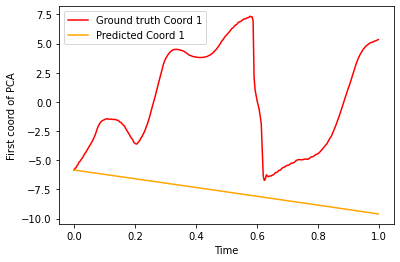

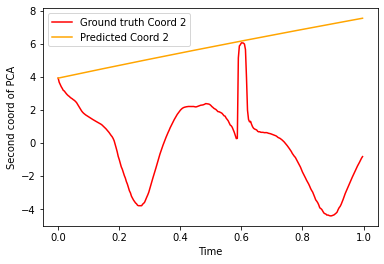

The graphs at epoch 1000


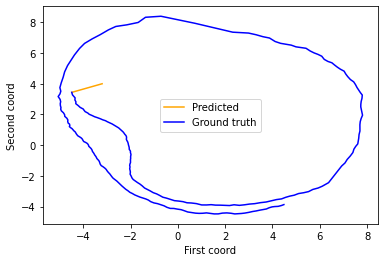

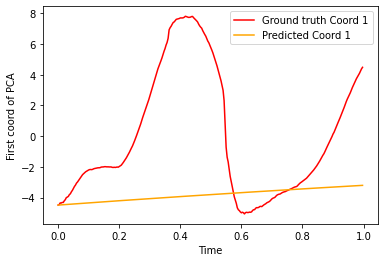

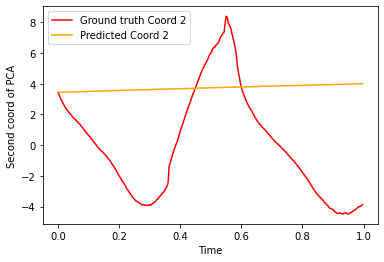

The graphs at epoch 1500


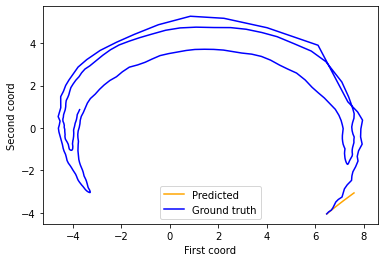

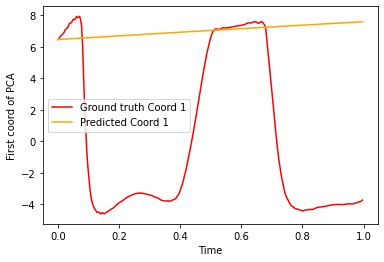

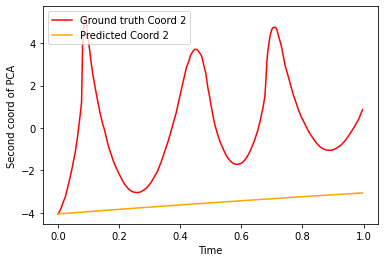

The graphs at epoch 2000


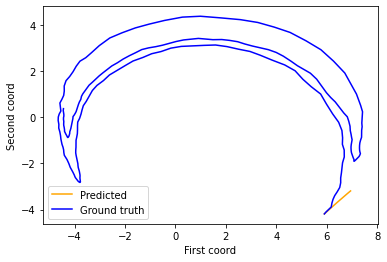

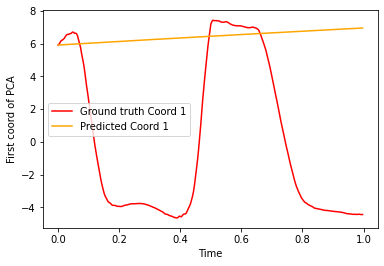

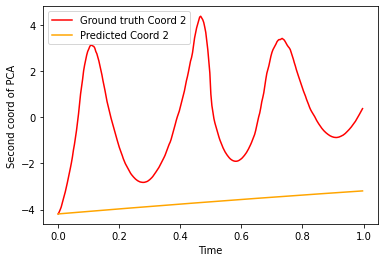

The graphs at epoch 2500


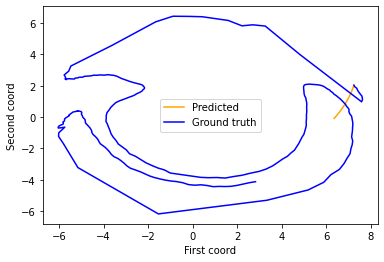

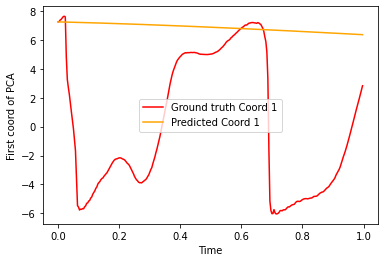

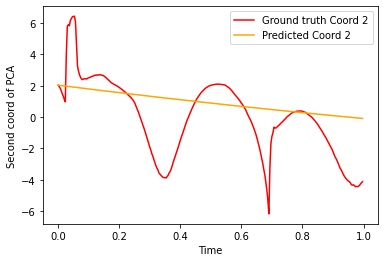

The graphs at epoch 3000


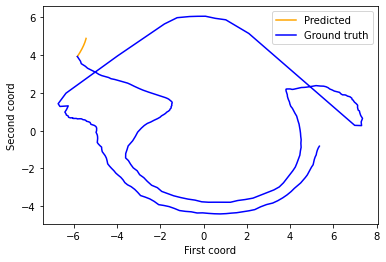

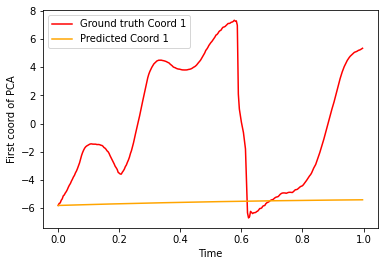

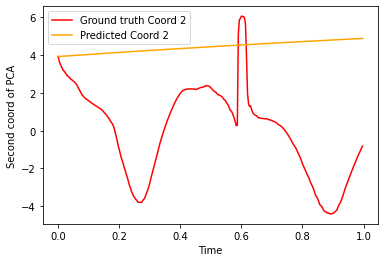

KeyboardInterrupt: 

In [14]:
train(anode, optimizer, scheduler, epochs, batch_size, getter, display=500, display_results_fn=display_results)